#import libraries

In [3]:
!pip install opendatasets

In [4]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
from PIL import Image
import opendatasets as od
from pathlib import Path
from collections import Counter
import pickle

#Download kaggle dataset

In [3]:
od.download(
    "https://www.kaggle.com/datasets/maciejgronczynski/biggest-genderface-recognition-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: b20ci045
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/maciejgronczynski/biggest-genderface-recognition-dataset


100%|██████████| 439M/439M [00:30<00:00, 15.1MB/s]


#load the dataset and define class names

In [13]:
# directory which contain data
data_dir = Path.cwd() / "biggest-genderface-recognition-dataset/faces"

# define the image size, batch size and channels
img_size = 224
batch_size = 32
channels = 3

# load data from hard disk to memory
dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                            image_size = (img_size,img_size),
                                                            batch_size = batch_size,
                                                            shuffle = True)

# define the labels (classes)
class_names = dataset.class_names

Found 27167 files belonging to 2 classes.


In [26]:
model_dir = Path.cwd() / 'saved_model'
model_dir.mkdir(parents = True, exist_ok = True)
file_name = model_dir / 'class_name.npy'
np.save(file_name,class_names)

#Visuallize the images in dataset

In [5]:
# function which shows the random images in dataset batch along with their labels
def random_images(dataset,class_name):
    plt.figure(figsize=(16,12))
    for image_batch,label_batch in dataset.take(1):
        if len(image_batch)!=32:
            random_images(dataset,class_name)
        else:
            for i in range(12):
                plt.subplot(3,4,i+1)
                random = np.random.randint(0,32)
                plt.imshow(image_batch[random].numpy().astype('uint8'))
                plt.title(f'{class_name[label_batch[random]]}')
                plt.axis('off')

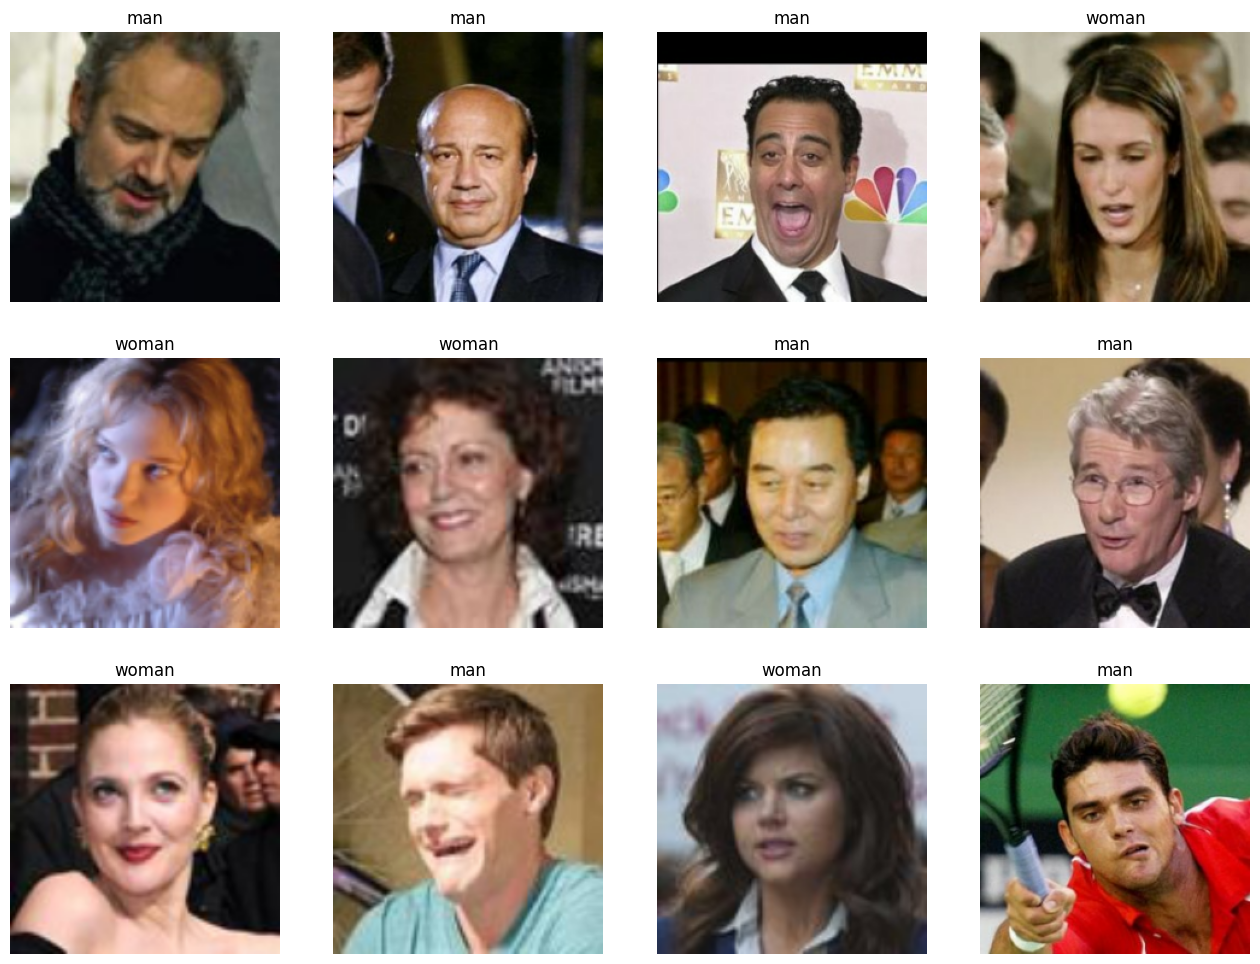

In [6]:
random_images(dataset,class_names)

#class distribution

In [7]:
man = len(os.listdir("biggest-genderface-recognition-dataset/faces/man"))
woman = len(os.listdir("biggest-genderface-recognition-dataset/faces/woman"))

In [8]:
def pie_plot(woman, man):
    plt.pie([woman, man], autopct='%1.1f%%', labels=('woman', 'man'), shadow=True, explode=(0.07, 0.05))
    plt.title("Gender distribution in biggest-genderface-recognition-dataset")
    plt.show()

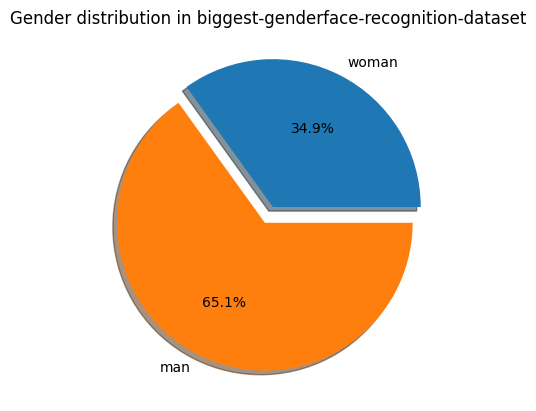

In [9]:
pie_plot(woman, man)

#split dataset into train-test-validation

In [14]:
# split the dataset into training, testing and validation batches
def train_test_split(dataset, shuffle = True, train_size = 0.7, val_size = 0.15, test_size = 0.15, shuffle_size = 10000):
    len_data = len(dataset)

    # shuffle the dataset before splitting
    if shuffle:
        dataset.shuffle(shuffle_size)

    train_size = int(train_size*len_data)
    val_size = int(val_size*len_data)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)

    return train_ds,test_ds,val_ds

In [15]:
train_ds, test_ds, val_ds = train_test_split(dataset)

In [16]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [17]:
# return the unbatched train dataset and test label
def unbatched_train_test_label(test_ds_batch):
    # params::
    # test_ds_batch : batched dataset used for testing purpose

    # lists for storing the training dataset and test label which is clubbed in test_ds_batch
    train_label = []
    test_label = []

    # loop for separating the training dataset and test label from test_ds_batch
    for train, test in test_ds_batch.unbatch().as_numpy_iterator():
        train_label.append(train)
        test_label.append(test)

    return np.array(train_label), np.array(test_label)

In [18]:
# train dataset and test label used for testing purpose - unbatched
train_label_ds, test_label_ds = unbatched_train_test_label(test_ds)

# visuallize the quantity of train-test-val

In [15]:
# Function to extract labels from the dataset
def extract_labels(dataset):
    labels = []
    for _, label in dataset:
        labels.extend(label.numpy())
    return labels


In [16]:
def get_count(dataset):
  # Extract labels from the dataset
  labels = extract_labels(dataset)

  # Count the occurrences of each label
  label_counts = Counter(labels)

  # Get the unique labels and their counts
  unique_labels, counts = zip(*label_counts.items())

  return unique_labels, counts

In [17]:
train_label, train_count = get_count(train_ds)
test_label,test_count = get_count(test_ds)
val_label, val_count = get_count(val_ds)

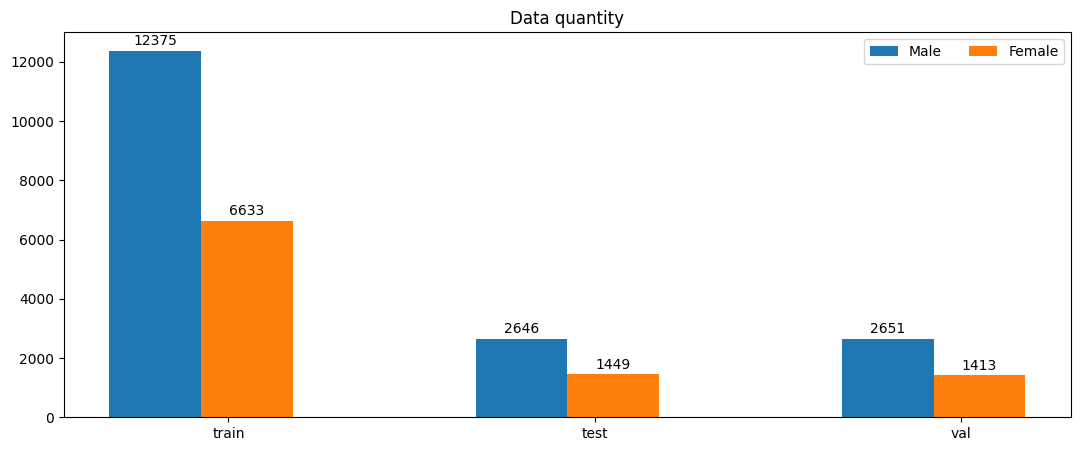

In [18]:
fig, plts = plt.subplots()
fig.set_size_inches(13, 5)

sets = ("train", "test","val")
set_quantity = {
    'Male': (train_count[train_label.index(0)], test_count[test_label.index(0)], val_count[val_label.index(0)]),
    'Female': (train_count[train_label.index(1)], test_count[test_label.index(1)], val_count[val_label.index(1)]),
}

x = np.arange(len(sets))
width = 0.25
multiplier = 0.2

for attribute, measurement in set_quantity.items():
    offset = width * multiplier
    rects = plts.bar(x + offset, measurement, width, label=attribute)
    plts.bar_label(rects, padding=2)
    multiplier += 1

plts.set_title("Data quantity")
plts.set_xticks(x + width, sets)
plts.legend(ncols=3)
plt.show()

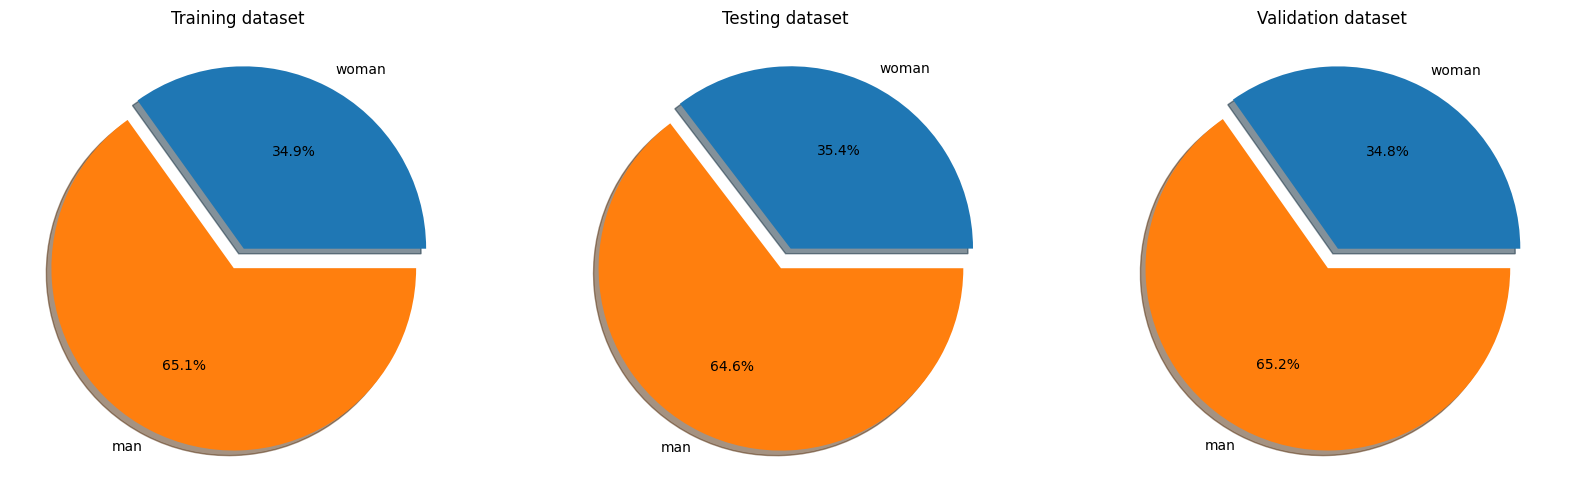

In [19]:
plt.figure(figsize = (20,15))

plt.subplot(1,3,1)
plt.pie([train_count[train_label.index(1)], train_count[train_label.index(0)]], autopct='%1.1f%%', labels=('woman', 'man'), shadow=True, explode=(0.07, 0.05))
plt.title("Training dataset")

plt.subplot(1,3,2)
plt.pie([test_count[test_label.index(1)], test_count[test_label.index(0)]], autopct='%1.1f%%', labels=('woman', 'man'), shadow=True, explode=(0.07, 0.05))
plt.title("Testing dataset")

plt.subplot(1,3,3)
plt.pie([val_count[val_label.index(1)], val_count[val_label.index(0)]], autopct='%1.1f%%', labels=('woman', 'man'), shadow=True, explode=(0.07, 0.05))
plt.title("Validation dataset")
plt.show()

# resize and augmentation layer

In [20]:
# resize and rescale layer
resize_and_rescale=keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(img_size,img_size),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
# data augmentation layer
data_augmentation=keras.Sequential([
    keras.layers.RandomFlip('horizontal_and_vertical'),
    keras.layers.RandomRotation(0.3),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomContrast(0.5)
])

#visualize the augmented images

In [22]:
# function which shows the augmented images
def augmented_img(dataset, class_name):
    plt.figure(figsize = (12,12))
    for image_batch,label_batch in dataset.take(1):
        if len(image_batch) != 32:
            random_images(dataset,class_name)
        else:
            for i in range(9):
                plt.subplot(3,3,i+1)
                aug_img = data_augmentation(image_batch)
                plt.imshow(aug_img[0].numpy().astype('uint8'))
                plt.axis('off')

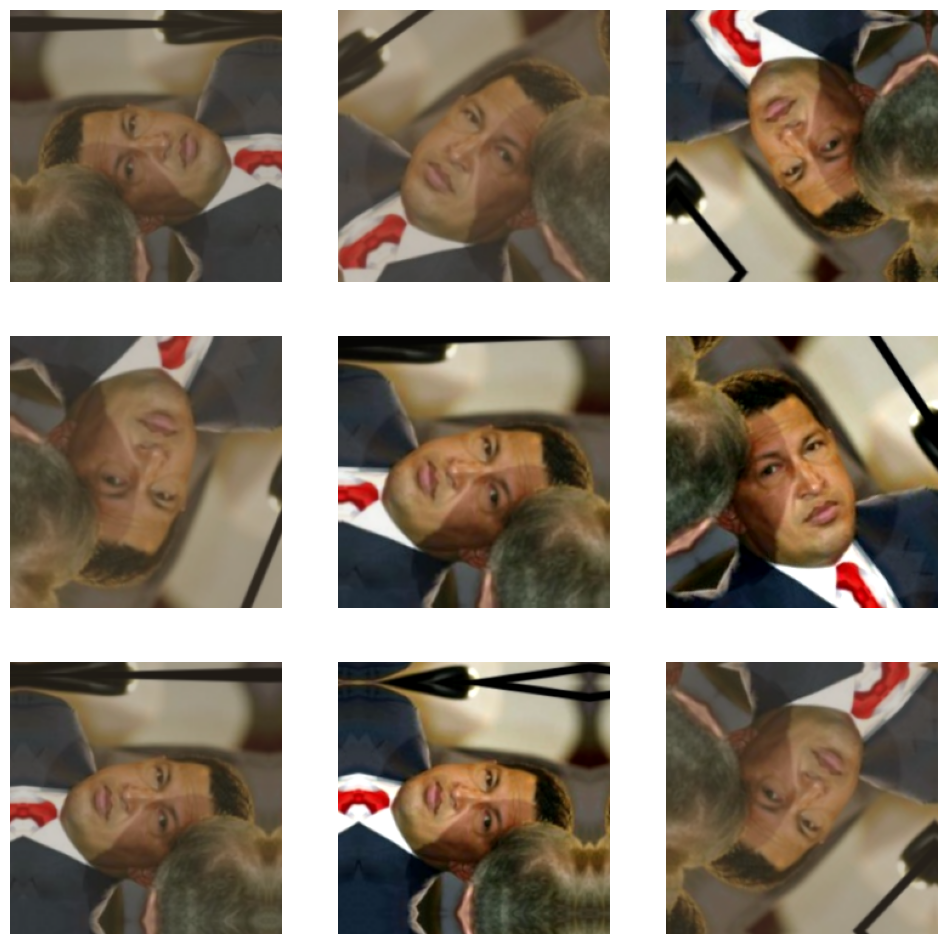

In [23]:
augmented_img(dataset, class_names)

#prepare pretrained model for fine-tuning (VGG16)

In [24]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

58889256/58889256 [==============================] - 4s 0us/step


In [25]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [26]:
# fuction which provide the layer from which weights are updated of pre-trained model during training
def fine_tune_at(base_model, fine_tune_from):
    # params::
    # base_model : pre-trained model
    # fine_tune_from : (int) (0 < fine_tune_from < len(base_model.layers))

    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = len(base_model.layers) - fine_tune_from
    return fine_tune_at

In [27]:
# define the pretreined custom model along with fine tuning
def pretrained_custom_model(base_model, data_augmentation, preprocess_input, freeze_layers_upto, base_learning_rate = 0.0001):
        # params:
        # base_model : pre-trained model
        # freeze_layers_upto : (int) layer upto which pre-trained model weights not changed

        # Freeze the layers of the pre-trained model
        for layer in base_model.layers[:freeze_layers_upto]:
            layer.trainable = False

        # adding custom layers for specific task
        inputs = tf.keras.Input(shape=(224, 224, 3))
        x = data_augmentation(inputs)
        x = preprocess_input(x)
        x = base_model(x, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(512, activation = "relu", kernel_regularizer = keras.regularizers.l2(l2 = 0.005))(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(256, activation = "relu", kernel_regularizer = keras.regularizers.l2(l2 = 0.005))(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        outputs = tf.keras.layers.Dense(2, activation = 'softmax')(x)

        # build the model
        model = tf.keras.Model(inputs, outputs)

        # define the optimizer, loss, and metrics for model compilation
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
                      loss = 'SparseCategoricalCrossentropy',
                      metrics = ['accuracy'])

        return model

In [28]:
base_learning_rate = 0.0001
freeze_layers_upto = fine_tune_at(base_model, 6)
model = pretrained_custom_model(base_model, data_augmentation, preprocess_input ,freeze_layers_upto , base_learning_rate)

Number of layers in the base model:  19


In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0     

#Train the model

In [30]:
# train the model and return model history along with trained model params
def train_model(model, train_ds, valid_ds, model_name, epochs = 10):
    # params::
    # model      : trained model
    # train_ds   : training dataset (contain images and labels)
    # val_ds     : validation dataset (contain images and labels)
    # model_name : directory name (str)

    #save the current directory path
    current_dir = Path.cwd()

    #create directory for storing callback model
    save_model_dir = Path.cwd() / 'saved_model' / f'{model_name}' / 'callbacks'
    save_model_dir.mkdir(parents = True, exist_ok = True)

    #change to the callback directory
    os.chdir(save_model_dir)
    checkpoint = keras.callbacks.ModelCheckpoint(f'{model_name}.h5', save_best_only = True, monitor = 'val_loss', mode = 'min', verbose = 1)

    # store the model history
    history = model.fit(
        train_ds,
        validation_data = valid_ds,
        epochs = epochs,
        callbacks = [checkpoint],
        verbose = 1,
    )

    #finally goes back to current directory
    os.chdir(current_dir)
    return history

In [31]:
epochs = 8
model_name = 'vgg16'
history = train_model(model, train_ds, val_ds, f'{model_name}', epochs)

Epoch 1/8
594/594 [==============================] - ETA: 0s - loss: 3.3604 - accuracy: 0.8020
Epoch 1: val_loss improved from inf to 2.09205, saving model to vgg16.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


594/594 [==============================] - 148s 224ms/step - loss: 3.3604 - accuracy: 0.8020 - val_loss: 2.0920 - val_accuracy: 0.9045
Epoch 2/8
594/594 [==============================] - ETA: 0s - loss: 1.5510 - accuracy: 0.9037
Epoch 2: val_loss improved from 2.09205 to 1.09924, saving model to vgg16.h5
594/594 [==============================] - 141s 238ms/step - loss: 1.5510 - accuracy: 0.9037 - val_loss: 1.0992 - val_accuracy: 0.9277
Epoch 3/8
594/594 [==============================] - ETA: 0s - loss: 0.8680 - accuracy: 0.9214
Epoch 3: val_loss improved from 1.09924 to 0.67901, saving model to vgg16.h5
594/594 [==============================] - 132s 222ms/step - loss: 0.8680 - accuracy: 0.9214 - val_loss: 0.6790 - val_accuracy: 0.9267
Epoch 4/8
594/594 [==============================] - ETA: 0s - loss: 0.5505 - accuracy: 0.9313
Epoch 4: val_loss improved from 0.67901 to 0.45967, saving model to vgg16.h5
594/594 [==============================] - 131s 221ms/step - loss: 0.5505 - acc

#Plot the traing-validation loss, traing-validation accuracy

In [32]:
# plot the traing-validation loss, traing-validation accuracy
def plot_history(history):
    # params:: history: model history stored after fitting (training)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize = (8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label = 'Training Accuracy')
    plt.plot(val_acc, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label = 'Training Loss')
    plt.plot(val_loss, label = 'Validation Loss')
    plt.legend(loc = 'upper right')
    plt.ylabel('SparseCategorical Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

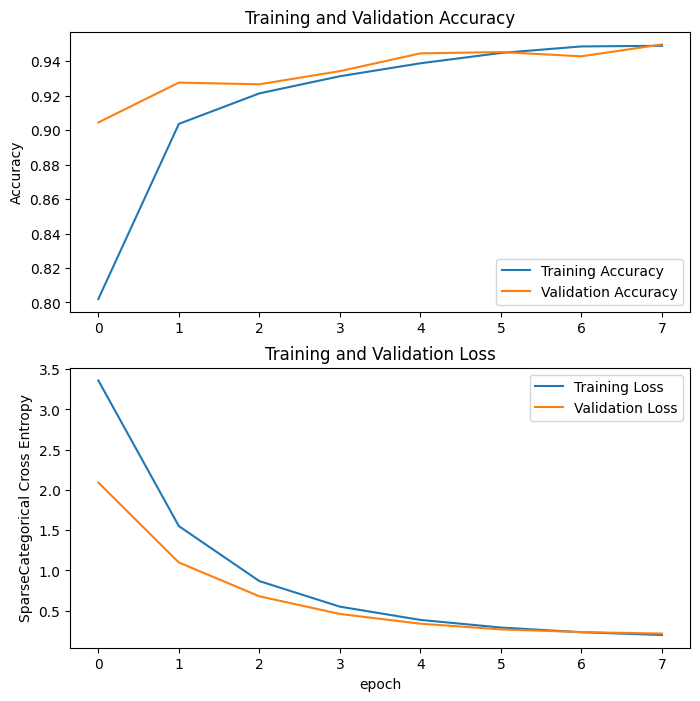

In [33]:
plot_history(history)

# display test dataset along with predictions

In [34]:
def display_test_ds_with_predictions(class_name, test_ds, model):
    # params:
    # class_name : list which containes classes / labels
    # test_ds    : test dataset
    # model      : trained model

    #loss and accuarcy
    loss, accuracy = model.evaluate(test_ds)
    print(f"loss = {loss:.4f},\naccuracy = {accuracy:.5f}")

    # Retrieve a batch of images from the test set
    image_batch, label_batch = test_ds.as_numpy_iterator().next()

    # predictions gives us the probability of images belonging to each class
    predictions = model.predict_on_batch(image_batch)

    # assign class which has max probability
    predictions_index = np.argmax(predictions, axis = 1)

    plt.figure(figsize=(16, 16))
    if len(image_batch)!=32:
            display_test_ds_with_predictions(class_name, test_ds, model)
    else:
        for i in range(9):
          plt.subplot(3, 3, i + 1)
          random = np.random.randint(0,32)
          plt.imshow(image_batch[random].astype("uint8"))
          plt.title(f"Actual label = {class_name[label_batch[random]]},\npredicted label = {class_name[(predictions_index[random])]},\nconfidence level = {np.round(np.max(predictions[random])*100,2)}%")
          plt.axis("off")

128/128 [==============================] - 47s 179ms/step - loss: 0.2171 - accuracy: 0.9429
loss = 0.2171,
accuracy = 0.94286


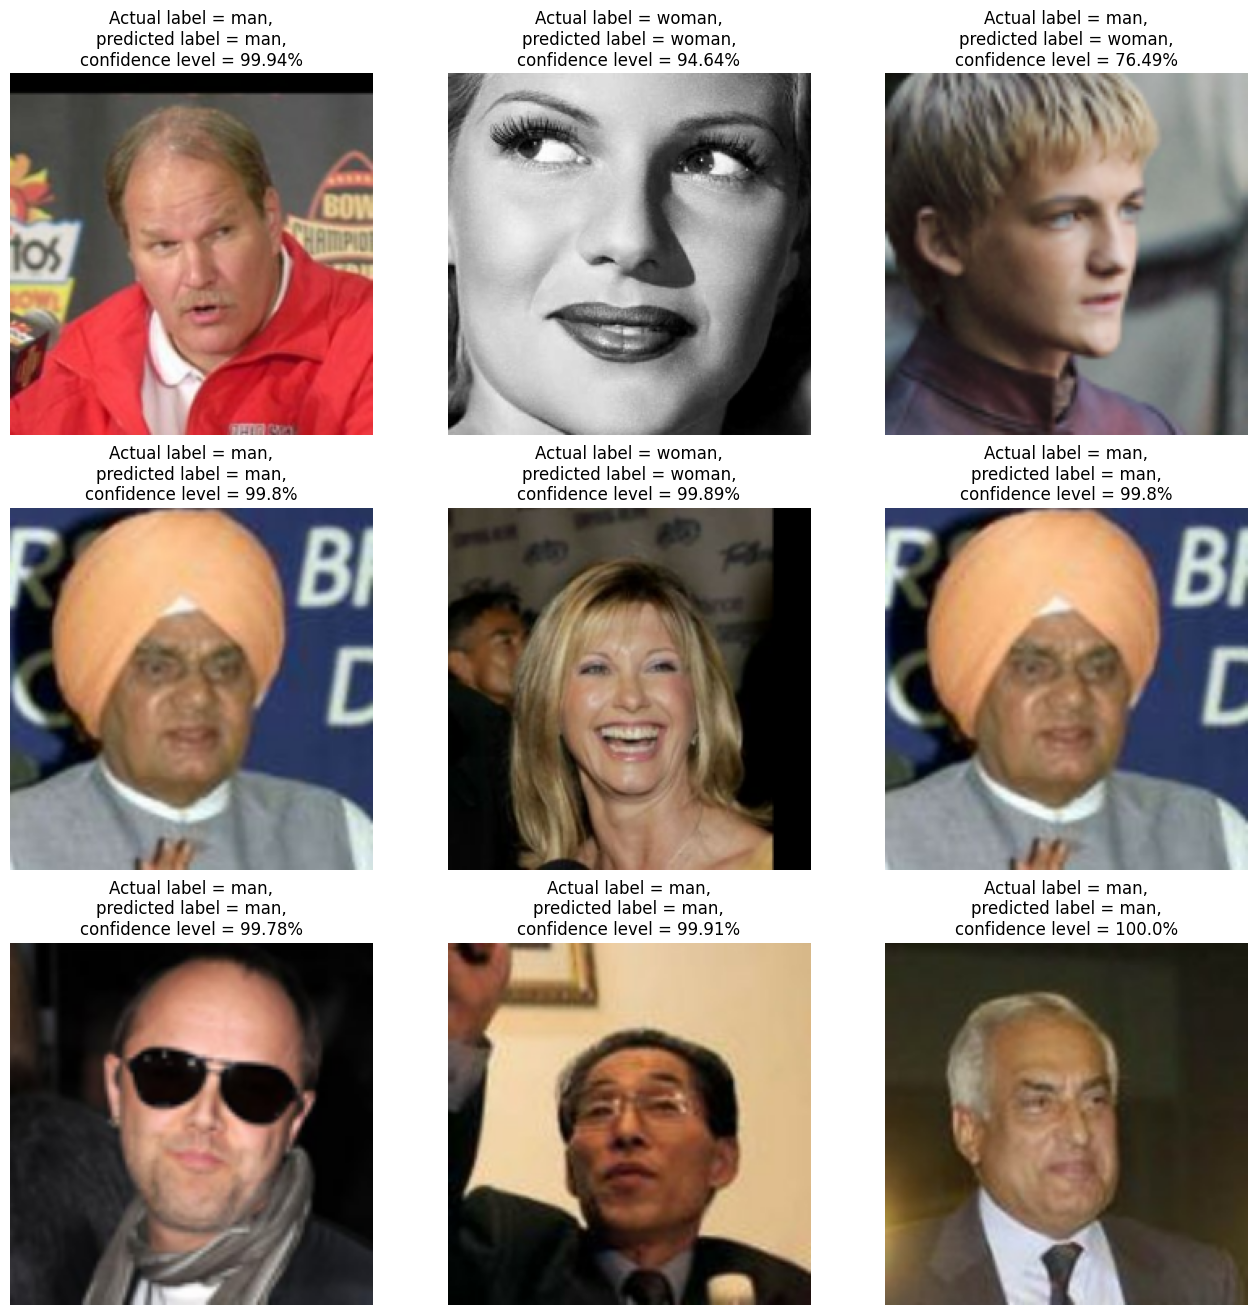

In [35]:
display_test_ds_with_predictions(class_names, test_ds, model)

# store the model along with history

In [39]:
# store the model history and model as well
def store_history_model(model_name, history, model):
    # params::
    # history    : model history stored after fitting (training)
    # model      : trained model
    # model_name : directory name (str)

    # create new directory for storing model as well as history
    model_dir = Path.cwd() / 'saved_model' / f'{model_name}'
    model_dir.mkdir(parents = True, exist_ok = True)

    # store the history
    hist_path = model_dir / 'history'

    #Extract history dictionary
    hist_dict = history.history

    pickle.dump(hist_dict, open(f'{hist_path}', 'wb'))

    # store the model
    model_path = model_dir / f'{model_name}.h5'
    model.save(model_path)

In [40]:
store_history_model(f'{model_name}', history, model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
# fuction which define the order in which function is called from training the model till saving the model
def pipeline(base_model, data_augmentation, preprocess_input, freeze_layers_upto, model_name, train_ds, val_ds, test_ds, class_name, epochs = 10,  base_learning_rate = 0.0001):
    model = pretrained_custom_model(base_model, data_augmentation, preprocess_input ,freeze_layers_upto , base_learning_rate)
    history = train_model(model, train_ds, val_ds, f'{model_name}', epochs)
    plot_history(history)
    display_test_ds_with_predictions(class_name, test_ds, model)
    store_history_model(f'{model_name}', history, model)

# Open saved model

In [5]:
# load the saved model into memory
def open_saved_model(model_name):
    # params:: model_name : directory name (str)

    hist_path = Path.cwd() / 'saved_model' / f'{model_name}' / 'history'
    history = pickle.load(open(f'{hist_path}', 'rb'))
    model_path = Path.cwd() / 'saved_model' / f'{model_name}' / f'{model_name}.h5'
    model = keras.models.load_model(model_path)
    return history, model

In [11]:
model_name = "vgg16"
history_open, model_open = open_saved_model(f'{model_name}')

In [9]:
# plot the traing-validation loss, traing-validation accuracy
def plot_history_saved(history):
    # params:: history: model history stored after fitting (training)

    acc = history['accuracy']
    val_acc = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    plt.figure(figsize = (8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label = 'Training Accuracy')
    plt.plot(val_acc, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label = 'Training Loss')
    plt.plot(val_loss, label = 'Validation Loss')
    plt.legend(loc = 'upper right')
    plt.ylabel('SparseCategorical Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

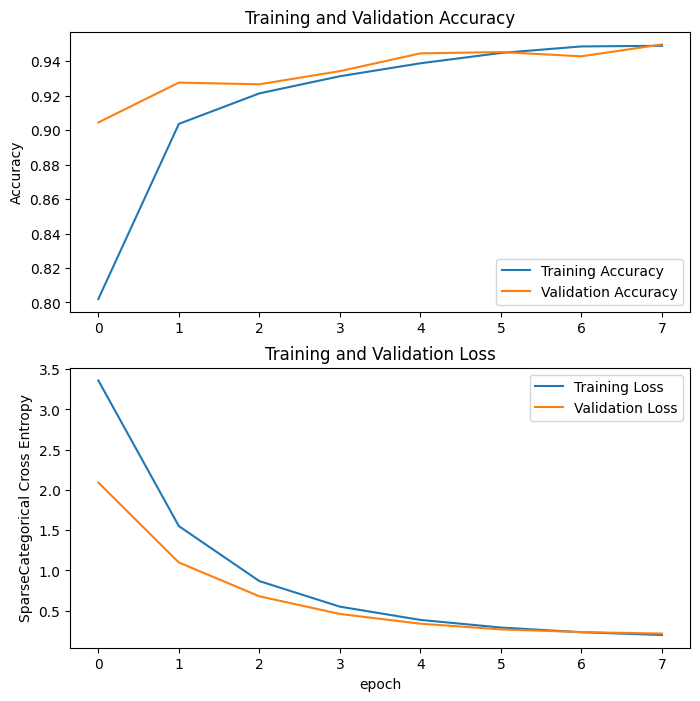

In [12]:
plot_history_saved(history_open)

# generate classification report

In [19]:
# return predicted labels
def predicted_label(train_label, model):
    # params::
    # train_label : unbatched train dataset
    # model : model used for prediction

    # predict the probabilities
    probabilities = model.predict(train_label, use_multiprocessing=True)

    # select label which has max probability
    predictions = np.argmax(probabilities, axis=1)

    return predictions


# classification report for multiclass
def generate_classification_report(y_true, y_pred):
    # params::
    # y_true : true test label (unbatched)
    # y_pred : predicted test label

    # generate classification report
    report = classification_report(y_true, y_pred)
    return report

In [20]:
predictions2 = predicted_label(train_label_ds, model_open)
print(generate_classification_report(test_label_ds, predictions2))

128/128 [==============================] - 29s 165ms/step
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2635
           1       0.96      0.90      0.93      1460

    accuracy                           0.95      4095
   macro avg       0.95      0.94      0.94      4095
weighted avg       0.95      0.95      0.95      4095



# plot confusion matrix

In [22]:
# plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    # params::
    # y_true : true test label (unbatched)
    # y_pred : predicted test label

    # calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='GnBu', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

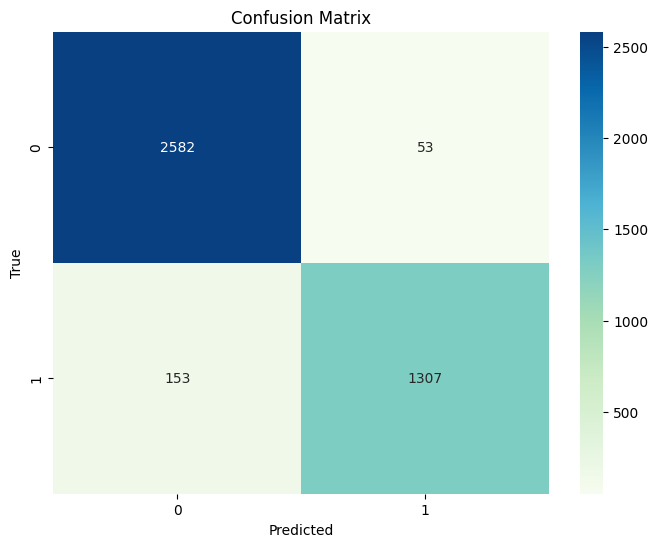

In [24]:
plot_confusion_matrix(test_label_ds, predictions2)

# predict the class of images which are taken from internet for testing purpose

In [25]:
def display_images(model, class_name, URL):
    # params::
    # URL : (str) website link
    # model : model used for prediction
    # class_name : list which containes classes / labels

    #create directory for test images
    path = Path.cwd() / 'Test Images'
    path.mkdir(parents = True, exist_ok = True)

    #download the image from internet using URL
    file_name = tf.keras.utils.get_file(origin = URL, cache_subdir = path, extract = True)

    #resize teh image, expand dimesion for predictions (3D but require 4D array)
    resize_img4_array=np.array(Image.open(file_name).resize((224, 224)))
    img4_array_batch=np.expand_dims(resize_img4_array,0)

    #prediction, class define, probability
    prediction=model.predict(img4_array_batch)
    class_ = class_name[np.argmax(prediction[0])]
    confidence = np.round(np.max(prediction[0])*100,2)

    #visuallize image
    plt.imshow(resize_img4_array)
    plt.title(f"class : {class_},\nconfidence : {confidence}%")
    plt.axis('off')

In [30]:
# load the class name
file_name = Path.cwd() / 'saved_model' / 'class_name.npy'
class_names = np.load(file_name)

1/1 [==============================] - 1s 1s/step


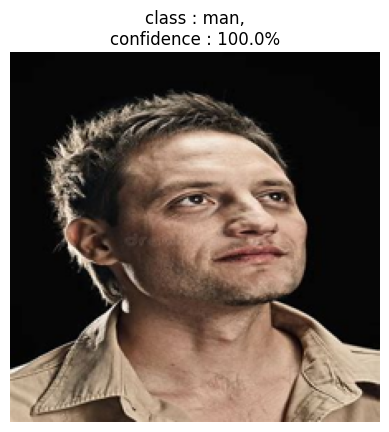

In [31]:
URL = "https://th.bing.com/th/id/OIP.IwSI927tuDbfurK9lwa48wHaLJ?w=203&h=306&c=7&r=0&o=5&dpr=1.3&pid=1.7"
display_images(model_open, class_names, URL)

1/1 [==============================] - 0s 143ms/step


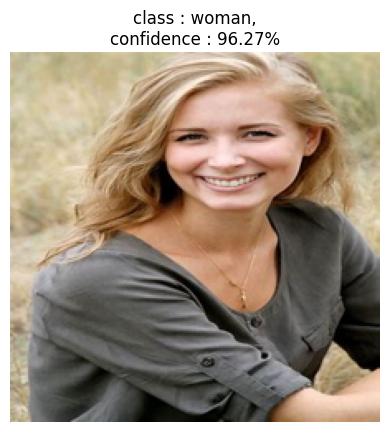

In [32]:
URL = "https://th.bing.com/th/id/OIP.88U_XTsYICEJKNBtXBG9gAHaLH?w=204&h=306&c=7&r=0&o=5&dpr=1.3&pid=1.7"
display_images(model_open, class_names, URL)